# Notes

Used data (setDeepLoc and setHARD) from paper "Light Attention Predicts Protein Location from the Language of Life" by Stärk et al. available at: https://github.com/HannesStark/protein-localization/tree/master/data_files

Original data from http://www.cbs.dtu.dk/services/DeepLoc/data.php.

**Data explanation**:
- setDeepLoc:
    - Train: 9503 proteins
    - Validation: 1158 proteins redundance reduced (<= 30% PIDE (pairwise sequence identity))
    - Test: 2768 proteins redundance reduce to the training set (<= 30% PIDE & E-values <= 10^-6)
- setHARD:
    - Test: 490 proteins representative of clusters at >= 20% PIDE of proteins from SwissProt (only eukaryote, no fragments, >= 40 residues and proteins deleting with >= 20% PIDE to all sets)


**Proposed splits**:
- From the original Stärk et al. paper data:
    - `mixed_soft`: deepLoc train + deepLoc validation + deepLoc test ---> Ready!
    - `mixed_hard`: deepLoc train + deepLoc validation + testHARD test ---> Ready!
- From the original Thumuluri et al. DeepLoc 2.0 paper data:
    - `mixed_vs_human_2`: deepLoc 2 train (mixed) + deepLoc 2 validation (mixed) + deepLoc 2 test (human) ---> Que hacer cuando mas de una clase?????
- New proposals:
    - `human_soft`: deepLoc train + deepLoc validation + deepLoc test (only human proteins) ---> Ready!
    - `human_hard`: deepLoc train + deepLoc validation + testHARD test (only human proteins) ---> Ready!
    - `mixed_balanced`: TODO
    - `human_balanced`: TODO

# Configs & Imports

In [1]:
import re

from pathlib import Path

from pandas import DataFrame, read_csv
import numpy as np
from matplotlib import pyplot as plt

from Bio import SeqIO

In [2]:
# Where the raw data is stored and where processed data will be deposited
data_path = Path('') / '..' / 'data' / 'subcellular_localization'
split_path = Path('') / '..' / 'splits' / 'scl'

# There are 4 datasets: TODO: CHANGE
# From original the original deepLoc: one for training, one for validation and one for test
# From Stärk et al. paper: one for test
train_data_path = data_path / 'deeploc_our_train_set.fasta'
validation_data_path = data_path / 'deeploc_our_val_set.fasta'
test_data_path = data_path / 'deeploc_test_set.fasta'
final_test_data_path = data_path / 'setHARD.fasta'
deepLoc2_train_and_val_data_path = data_path / 'Swissprot_Train_Validation_dataset.csv'
deepLoc2_test_data_path = data_path / 'hpa_testset.csv'

# For the human data, we need to map gene names to UniProt accessions
# Then we use a TSV export from UniProt to map the sequence to the gene name # TODO
human_sequences_path = data_path / 'human_sequences.tsv'

# Obtain original datasets

In [3]:
# Function to encapsulate the reading of the four data files
def getProteinsFromFASTAFile(filePath):
    columns = ["id", "name", "location", "sequence"]
    dataset = DataFrame(columns = columns)
    
    for protein in SeqIO.parse(filePath, "fasta"):
        dataset = dataset.append({"id": protein.id,
                                            "name": protein.name,
                                            "location": protein.description.split(" ")[1],
                                            #"Location": re.search(r'[a-zA-Z]*\.([a-zA-Z]*)-[a-zA-Z]*', record.description).group(1), 
                                            "sequence": str(protein.seq)}, ignore_index=True)
    
    return dataset

In [4]:
# Obtain data from sets
train_set_full = getProteinsFromFASTAFile(train_data_path)
validation_set_full = getProteinsFromFASTAFile(validation_data_path)
test_set_full = getProteinsFromFASTAFile(test_data_path)
test_set_hard = getProteinsFromFASTAFile(final_test_data_path)
deepLoc2_train_and_val = read_csv(deepLoc2_train_and_val_data_path)
deepLoc2_test = read_csv(deepLoc2_test_data_path)

# Obtain human data
human_sequences_data = read_csv(human_sequences_path, sep='\t')

In [5]:
# Simplificate classes (e.g. Nucleus-S and Nucleus-M to Nucleus)
modification = lambda row : row["location"].split("-")[0].replace(".", " ")

train_set_full["location"] = train_set_full.apply(modification, axis = 1)
validation_set_full["location"] = validation_set_full.apply(modification, axis = 1)
test_set_full["location"] = test_set_full.apply(modification, axis = 1)
test_set_hard["location"] = test_set_hard.apply(modification, axis = 1)

# From original paper data

## mixed_soft (deepLoc train + deepLoc validation + deepLoc test)

In [5]:
mixed_soft = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train set (deepLoc)
tmp = train_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(train_set_full))
mixed_soft = mixed_soft.append(tmp)

# Add validation set (deepLoc)
tmp = validation_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(validation_set_full))
tmp.insert(2, "validation", [True]*len(validation_set_full))
mixed_soft = mixed_soft.append(tmp)

# Add test set (deepLoc)
tmp = test_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(test_set_full))
mixed_soft = mixed_soft.append(tmp)

mixed_soft = mixed_soft.reset_index(drop = True)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [8]:
mixed_soft.to_csv(split_path / 'splits' / 'mixed_soft.csv', index = False)

## mixed_hard (deepLoc train + deepLoc validation + testHARD test)

In [9]:
mixed_hard = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train set (deepLoc)
tmp = train_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(train_set_full))
mixed_hard = mixed_hard.append(tmp)

# Add validation set (deepLoc)
tmp = validation_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(validation_set_full))
tmp.insert(2, "validation", [True]*len(validation_set_full))
mixed_hard = mixed_hard.append(tmp)

# Add test set (setHARD)
tmp = test_set_hard[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(test_set_hard))
mixed_hard = mixed_hard.append(tmp)

mixed_hard = mixed_hard.reset_index(drop = True)

In [10]:
mixed_hard.to_csv(split_path / 'splits' / 'mixed_hard.csv', index = False)

## mixed_vs_human_2 (deepLoc 2 train (mixed) + deepLoc 2 validation (mixed) + deepLoc 2 test (human))

In [5]:
# Simplificate the training/validation dataset
deepLoc2_train_and_val = deepLoc2_train_and_val.drop(deepLoc2_train_and_val.columns[0], axis=1)
deepLoc2_train_and_val = deepLoc2_train_and_val.drop('Kingdom', axis=1)
deepLoc2_train_and_val = deepLoc2_train_and_val.drop('Membrane', axis=1)

# Simplificate the test dataset
deepLoc2_test = deepLoc2_test.drop('sid', axis=1)
deepLoc2_test = deepLoc2_test.drop('Lengths', axis=1)

In [6]:
classes_columns_names = ['Cytoplasm', 'Nucleus', 'Cell membrane', 'Mitochondrion', 'Endoplasmic reticulum', 'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome', 'Extracellular', 'Plastid']
# Delete instances with more than one class from train/val set (6684 instances from a total amount of 28303)
to_delete = []
for index, row in deepLoc2_train_and_val.iterrows():
    if row[classes_columns_names].sum() > 1:
        to_delete.append(index)
deepLoc2_train_and_val = deepLoc2_train_and_val.drop(labels=to_delete, axis=0)

# Delete instances with more than one class from test set (350 instances from a total amount of 1717)
to_delete = []
for index, row in deepLoc2_test.iterrows():
    if row[classes_columns_names[:-2]].sum() > 1: # Except extracellular and plastid. There are no instances of these classes in the test set
        to_delete.append(index)
deepLoc2_test = deepLoc2_test.drop(labels=to_delete, axis=0)

In [7]:
# Transform multicolumn classes to a single column class
deepLoc2_train_and_val['Class'] = deepLoc2_train_and_val[classes_columns_names].idxmax(1).where(deepLoc2_train_and_val.any(1))
deepLoc2_test['Class'] = deepLoc2_test[classes_columns_names[:-2]].idxmax(1).where(deepLoc2_test.any(1))

In [8]:
# Delete multicolumn classes
deepLoc2_train_and_val = deepLoc2_train_and_val.drop(classes_columns_names, axis=1)
deepLoc2_test = deepLoc2_test.drop(classes_columns_names[:-2], axis=1)

<AxesSubplot:>

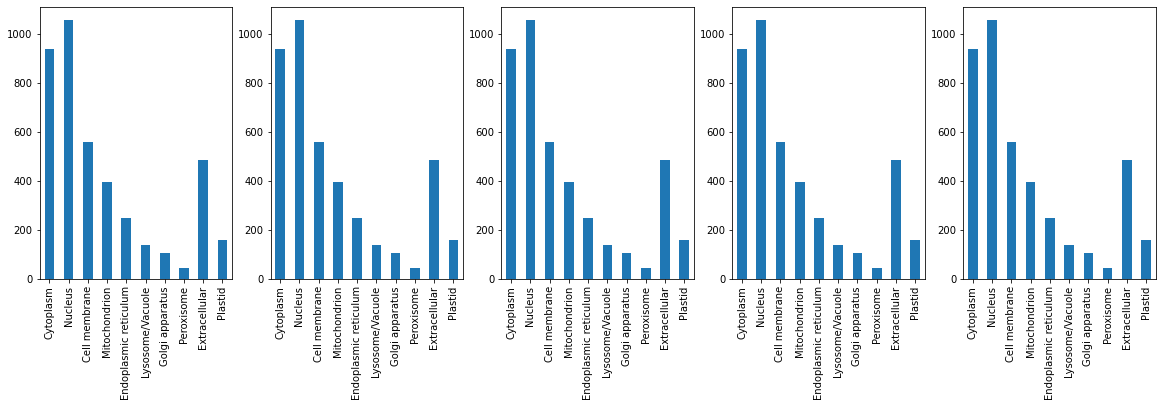

In [9]:
fig, axes = plt.subplots(figsize=(20,5), nrows=1, ncols=5)

partition0 = deepLoc2_train_and_val.loc[deepLoc2_train_and_val['Partition'] == 0]
partition1 = deepLoc2_train_and_val.loc[deepLoc2_train_and_val['Partition'] == 1]
partition2 = deepLoc2_train_and_val.loc[deepLoc2_train_and_val['Partition'] == 1]
partition3 = deepLoc2_train_and_val.loc[deepLoc2_train_and_val['Partition'] == 3]
partition4 = deepLoc2_train_and_val.loc[deepLoc2_train_and_val['Partition'] == 4]


partition1['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=axes[0])
partition1['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=axes[1])
partition1['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=axes[2])
partition1['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=axes[3])
partition1['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=axes[4])

In [10]:
# Length of each partition
print(str(len(partition1)) + " " + str(len(partition2)) + " " + str(len(partition3)) + " " + str(len(partition4)))

4122 4122 4356 4268


In [11]:
# All partitions looks equally so we can simply ignore the column
deepLoc2_train_and_val = deepLoc2_train_and_val.drop('Partition', axis=1)

# Sample instances for the validation set over the 10% of the total amount of sequences
deepLoc2_validation = deepLoc2_train_and_val.sample(frac=0.1, random_state=1234)

<AxesSubplot:>

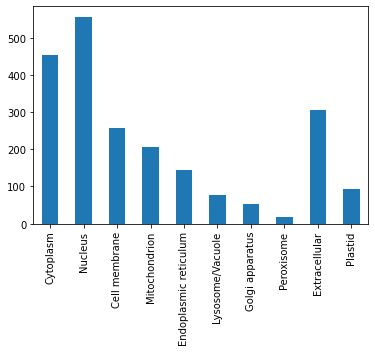

In [12]:
# Check if the validation set preserves the data distribution
deepLoc2_validation['Class'].value_counts().reindex(classes_columns_names).plot(kind='bar')

In [13]:
# Delete from the test set the instances for the validation set
deepLoc2_train = deepLoc2_train_and_val.drop(deepLoc2_validation.index, axis=0)

In [18]:
mixed_vs_human_2 = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train set (deepLoc 2 train (mixed))
tmp = deepLoc2_train[["Sequence", "Class"]]
tmp.rename(columns = {"Sequence": "sequence", "Class": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(deepLoc2_train))
mixed_vs_human_2 = mixed_vs_human_2.append(tmp)

# Add validation set (deepLoc)
tmp = deepLoc2_validation[["Sequence", "Class"]]
tmp.rename(columns = {"Sequence": "sequence", "Class": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(deepLoc2_validation))
tmp.insert(2, "validation", [True]*len(deepLoc2_validation))
mixed_vs_human_2 = mixed_vs_human_2.append(tmp)

# Add test set (deepLoc 2 test (human))
tmp = deepLoc2_test[["fasta", "Class"]]
tmp.rename(columns = {"fasta": "sequence", "Class": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(deepLoc2_test))
mixed_vs_human_2 = mixed_vs_human_2.append(tmp)

mixed_vs_human_2 = mixed_vs_human_2.reset_index(drop = True)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
mixed_vs_human_2.to_csv(split_path / 'splits' / 'mixed_vs_human_2.csv', index = False)

# New proposals

## human_soft (deepLoc train + deepLoc validation + deepLoc test (only human proteins))

In [11]:
human_soft = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train set (deepLoc)
tmp = train_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(train_set_full))
human_soft = human_soft.append(tmp)

# Add validation set (deepLoc)
tmp = validation_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(validation_set_full))
tmp.insert(2, "validation", [True]*len(validation_set_full))
human_soft = human_soft.append(tmp)

In [19]:
# Get human protein names
human_protein_names = set(human_sequences_data['Entry'])

# Get human proteins from test_set_full if human proteins
human_in_test_set_full = test_set_full.loc[test_set_full['name'].isin(human_protein_names)]

In [20]:
# Add test set (deepLoc)
tmp = human_in_test_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(human_in_test_set_full))
human_soft = human_soft.append(tmp)

human_soft = human_soft.reset_index(drop = True)

/Users/joaquimgomez/opt/anaconda3/envs/rostlab/lib/python3.8/site-packages/pandas/core/frame.py:5034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [22]:
human_soft.to_csv(split_path / 'splits' / 'human_soft.csv', index = False)

## human_hard (deepLoc train + deepLoc validation + testHARD test (only human proteins))

In [23]:
human_hard = DataFrame(columns = ["sequence", "target", "set", "validation"])

# Add train set (deepLoc)
tmp = train_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(train_set_full))
human_hard = human_hard.append(tmp)

# Add validation set (deepLoc)
tmp = validation_set_full[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["train"]*len(validation_set_full))
tmp.insert(2, "validation", [True]*len(validation_set_full))
human_hard = human_hard.append(tmp)

In [24]:
# Get human proteins from test_set_hard if human proteins
human_in_test_set_hard = test_set_hard.loc[test_set_hard['name'].isin(human_protein_names)]

In [25]:
# Add test set (setHARD)
tmp = human_in_test_set_hard[["sequence", "location"]]
tmp.rename(columns = {"location": "target"}, inplace = True)
tmp.insert(2, "set", ["test"]*len(human_in_test_set_hard))
human_hard = human_hard.append(tmp)

human_hard = human_hard.reset_index(drop = True)

In [26]:
human_hard.to_csv(split_path / 'splits' / 'human_hard.csv', index = False)

## balanced

<AxesSubplot:>

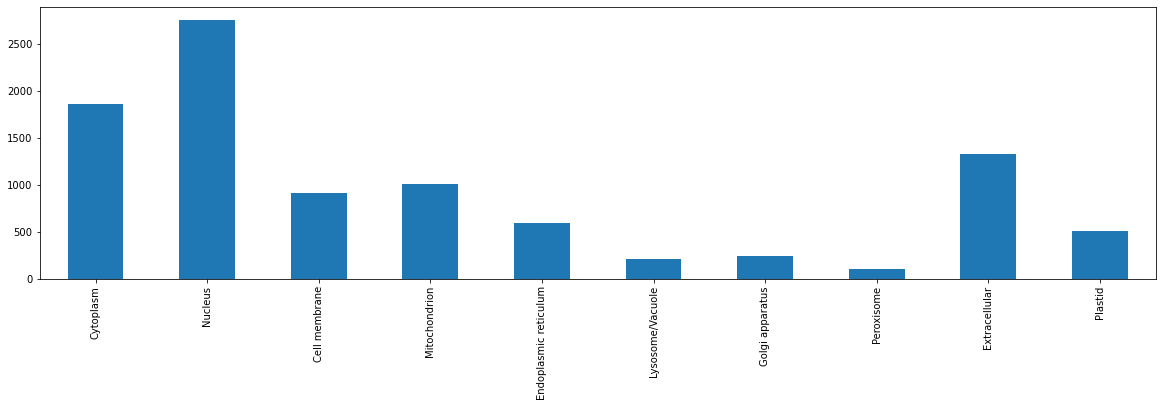

In [21]:
# Let's take a look at the distribution of train_set_full and test_set hard used for mixed_hard
fig = plt.figure(figsize = (20,5))
ax = fig.gca()

classes_columns_names = ['Cytoplasm', 'Nucleus', 'Cell membrane', 'Mitochondrion', 'Endoplasmic reticulum', 'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome', 'Extracellular', 'Plastid']
train_set_full['location'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=ax)

<AxesSubplot:>

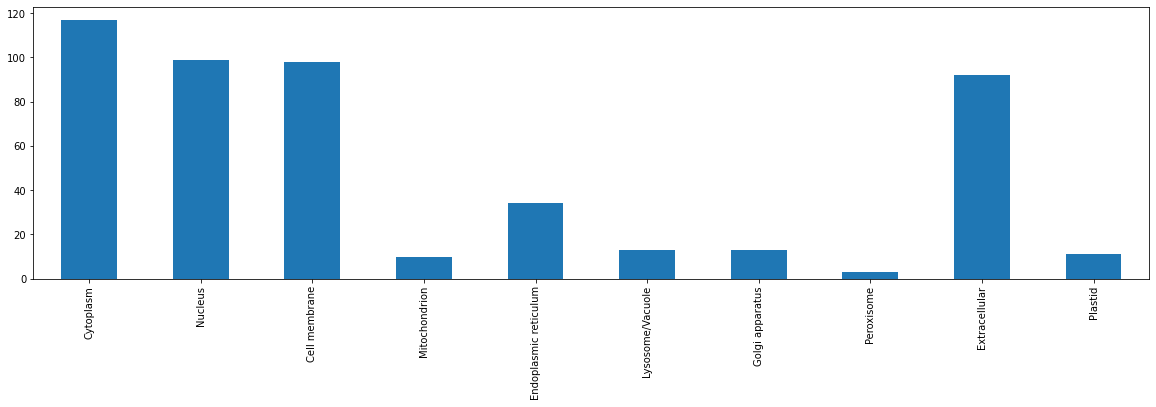

In [22]:
fig = plt.figure(figsize = (20,5))
ax = fig.gca()

test_set_hard['location'].value_counts().reindex(classes_columns_names).plot(kind='bar', ax=ax)

In [ ]:
# Let's perform a 